In [64]:
import cartopy.crs as ccrs
import csv
from dataclasses import asdict
from datetime import datetime, timedelta
import easygems.healpix as egh
from importlib import reload
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, find_ec_lon
import pandas as pd

In [145]:
# Define dates for forecast initialization and flight
# Airport Restrictions. None for 18.8.
# Meet EarthCARE South of ITCZ or in the South of the ITCZ (if there is less clouds)  (Silke)

issued_time = datetime(2024, 8, 19, 0, 0, 0)   # ???
issued_time_str = issued_time.strftime('%Y-%m-%d')

flight_time = datetime(2024, 8, 22, 12, 0, 0)         # ??? start date and time
flight_time_str = flight_time.strftime('%Y-%m-%d')
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print("Initalization date of IFS forecast: " + issued_time_str + "\nFlight date: " + flight_time_str + "\nFlight index: " + flight_index)

Initalization date of IFS forecast: 2024-08-19
Flight date: 2024-08-22
Flight index: HALO-20240822a


In [146]:
# Domain definition
# TO DO: replace by global definition once it exists
lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

In [232]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(refdate=issued_time_str, reftime='00').to_dask().pipe(egh.attach_coords)

In [148]:
issued_time_str

'2024-08-19'

In [235]:
# Load ec satellite track for 
track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-19", kind="PRE").get_track_for_day(flight_time_str)
track = track.sel(time=slice(flight_time_str + " 06:00", None))
ec_lons, ec_lats = track.lon.values, track.lat.values

**Waypoint definitions**

In [236]:
# Mass flux circle radius (m)
radius = 133e3

In [267]:
# ITCZ edges visually estimated from iwv contours

lat_edge_southn = 7.0 
lat_edge_south = 6.0    # ???
lat_edge_north = 13.3   # ???
lat_edge_center = 9.5
lat_edge_centern = 10.5
lat_edge_centers = 8.5

In [276]:
# ?
band = "east"

airport = sal if band == "east" else bco

# Point where we enter ec track? visually estimated? Rename to "lat_track_entry_north"?
lat_north = 19.0 # 10th percentile     #???
lat_south = 4.0 # 5th percentile - 1°  #??? 

lat_north_ec = 17.0
lat_meet_ec = 15.75
lat_south_ec = 14.5

lat_mindelo =  16.877833
lon_mindelo = -24.994975

lat_atr_circle_east = 16.4212
lon_atr_circle_east = -21.8315

lat_atr_circle_ec = 17.7

In [277]:
# Setting lat/lon coordinates

# Points where we get on ec track?
north = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), "north")
south = LatLon(lat_south, find_ec_lon(lat_south, ec_lons, ec_lats), "south")

north_ec = LatLon(lat_north_ec, find_ec_lon(lat_north_ec, ec_lons, ec_lats), "north_ec")
meet_ec = LatLon(lat_meet_ec, find_ec_lon(lat_meet_ec, ec_lons, ec_lats), "meet_ec")
south_ec = LatLon(lat_south_ec, find_ec_lon(lat_south_ec, ec_lons, ec_lats), "south_ec")

# Intersection of ITCZ edges with ec track
edge_north = LatLon(lat_edge_north, find_ec_lon(lat_edge_north, ec_lons, ec_lats), "edge_north")
edge_south = LatLon(lat_edge_south, find_ec_lon(lat_edge_south, ec_lons, ec_lats), "edge_south")
edge_southn = LatLon(lat_edge_southn, find_ec_lon(lat_edge_southn, ec_lons, ec_lats), "edge_south_alt")

circle_atr_ec = LatLon(lat_atr_circle_ec, find_ec_lon(lat_atr_circle_ec, ec_lons, ec_lats),'circle_atr_ec')
circle_atr_east = LatLon(lat_atr_circle_north, lon_atr_circle_north, 'circle_atr_north')

mindelo = LatLon(lat_mindelo, lon_mindelo,'mindelo')

# Center of middle circle
#center = edge_south.towards(edge_north).assign_label("center")
center = LatLon(lat_edge_center, find_ec_lon(lat_edge_center, ec_lons, ec_lats), "edge_center")
centern = LatLon(lat_edge_centern, find_ec_lon(lat_edge_centern, ec_lons, ec_lats), "edge_center_alt")
centers = LatLon(lat_edge_centers, find_ec_lon(lat_edge_centers, ec_lons, ec_lats), "edge_center_alt")

# Southern return point
returnPoint = north if band == "east" else LatLon(bco.lat, -53.0, "")


# What does leg refer to?
leg_south = [
     airport,
     north_ec,
     north,
     IntoCircle(circle_atr_ec, 70e3, 360),
     north_ec,
     south_ec,
     south
]

leg_circles = [
     IntoCircle(edge_south, radius, 360),
     IntoCircle(center, radius, 360),     
     IntoCircle(edge_north, radius, 360),
]
    
leg_home = [
     south_ec,
     mindelo,
     IntoCircle(circle_atr_ec, 70e3, 360),
     airport
]

waypoints = leg_south + leg_circles + leg_home 

path = fp.expand_path(waypoints, dx=10e3)

#print(f"duration: {halo_flight_duration(path)}")

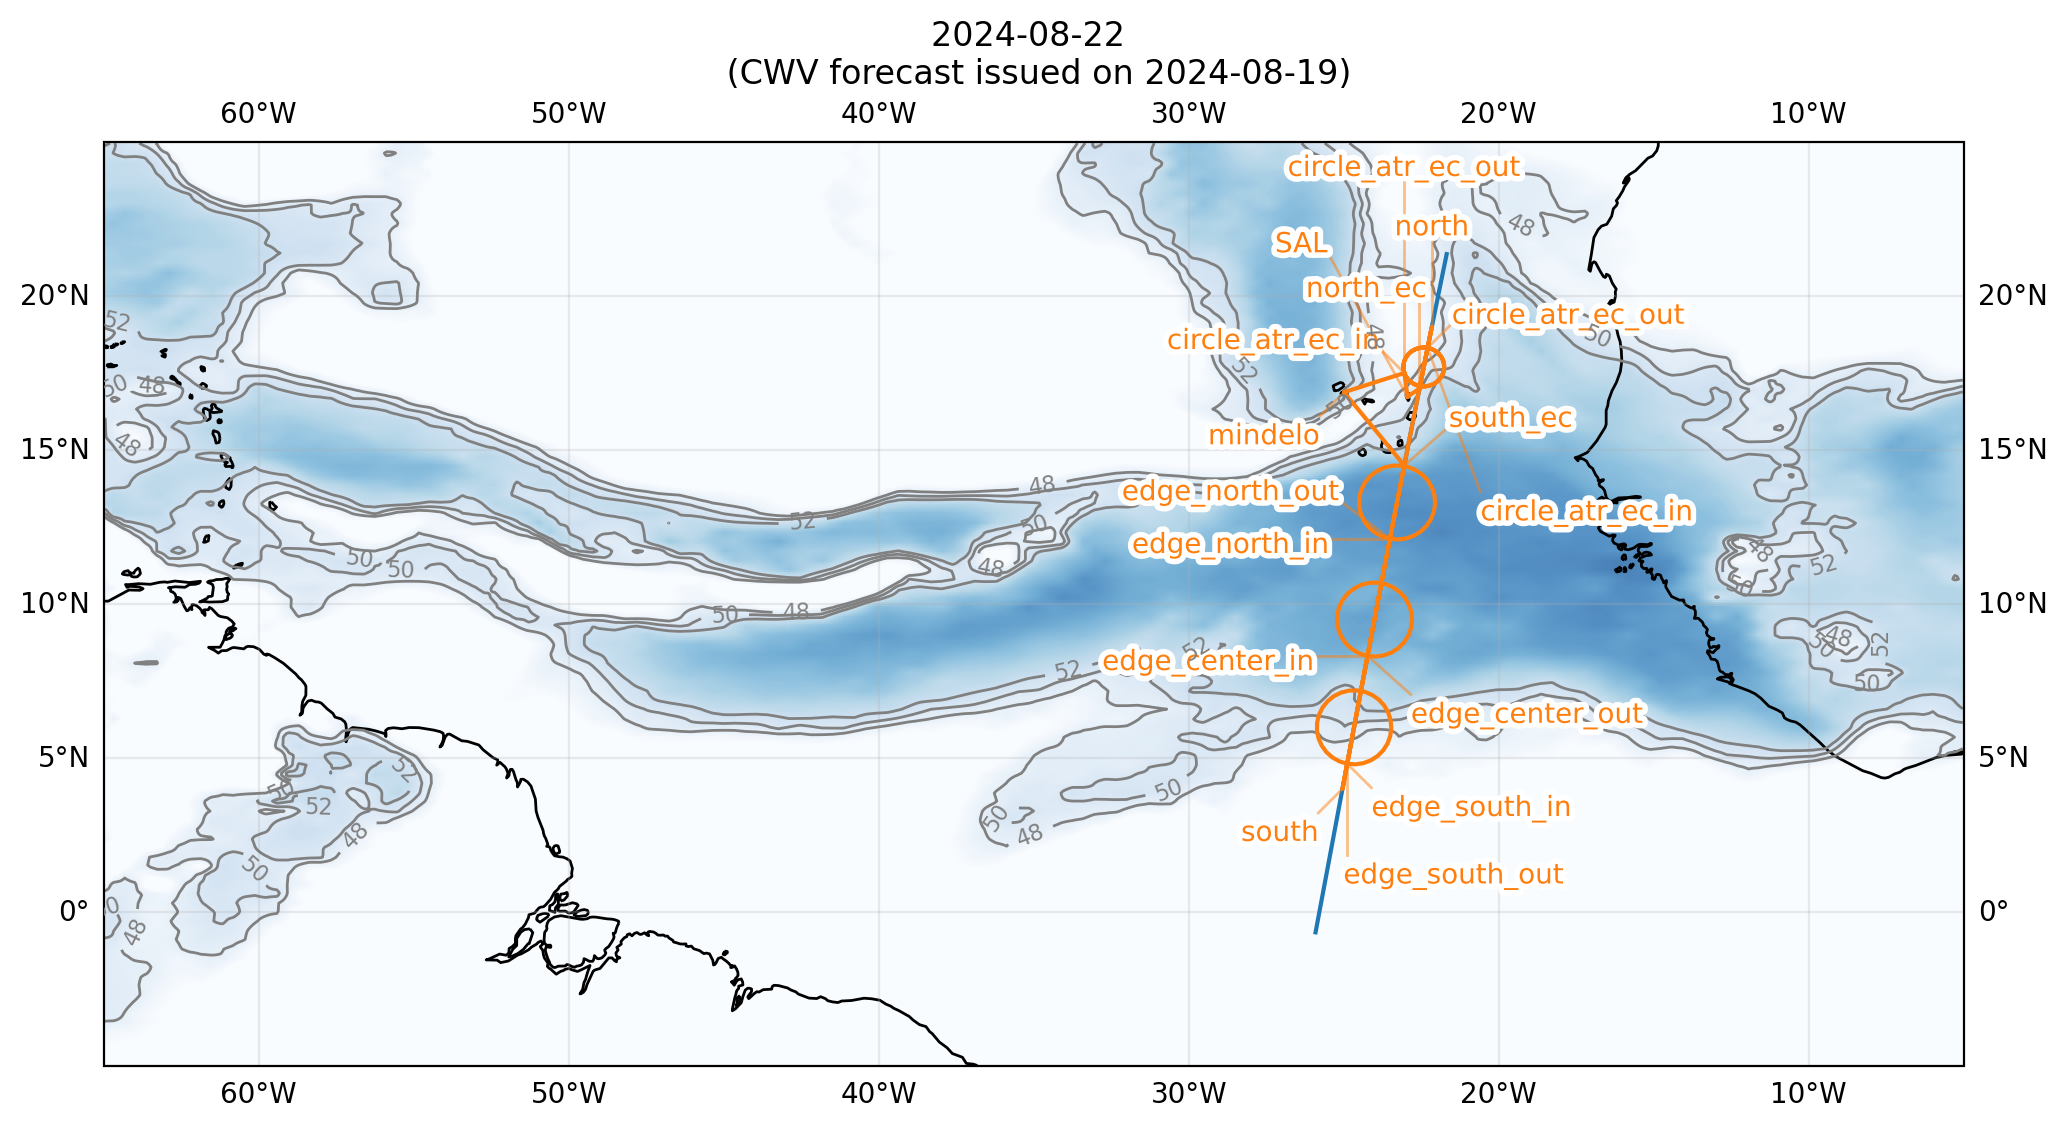

In [282]:
plt.figure(figsize = (12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)


cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [48.0, 50.0, 52.0])
plt.title(f"{flight_time_str} \n (CWV forecast issued on {issued_time_str})")

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")
plt.savefig('PERCUSION_HALO-20240822a_v3.png', bbox_inches='tight')

In [281]:
pd.DataFrame.from_records(map(asdict, [mindelo, 
                                       north,
                                       south,
                                       circle_atr_ec,
                                       north_ec,
                                       meet_ec,
                                       south_ec,
                                       edge_north,
                                       center,
                                       centern, 
                                       centers,
                                       edge_south,
                                       edge_southn,
                                       mindelo,
                                       south])).set_index("label")

,lat,lon,fl,time
label,,,,
mindelo,16.877833,-24.994975,None,None
north,19.000000,-22.159385,None,None
south,4.000000,-25.041859,None,None
circle_atr_ec,17.700000,-22.419178,None,None
north_ec,17.000000,-22.557878,None,None
meet_ec,15.750000,-22.804044,None,None
south_ec,14.500000,-23.048144,None,None
edge_north,13.300000,-23.280716,None,None
edge_center,9.500000,-24.007665,None,None


In [275]:
for coord in [north, center, south]:
    print(coord.format_pilot())

N19 00.00, W022 09.56
N09 30.00, W024 00.46
N05 00.00, W024 51.29


In [ ]:
import dataclasses
from typing import Optional
from dataclasses import dataclass

def get_deg(decimal):
    return int(decimal)

def get_min(decimal):
    return abs(decimal - int(decimal)) * 60

def get_deg_min(coord):
    de = int(abs(coord))
    mi = (abs(coord) - de) * 60
    if coord < 0:
        return -de, -mi
    else:
        return de, mi
        
@dataclass(frozen=True)
class LatLon:
    lat: float
    lon: float
    label: Optional[str] = None
    fl: Optional[float] = None

    def towards(self, other, fraction=None, distance=None) -> LatLon:
        if fraction is None and distance is None:
            fraction = 0.5

        (az12, az21, dist) = geod.inv(self.lon, self.lat, other.lon, other.lat)

        if distance is None:
            distance = dist * fraction

        return self.course(az12, distance)

    def course(self, direction, distance) -> LatLon:
        lon, lat, _ = geod.fwd(self.lon, self.lat, direction, distance)
        return LatLon(lat, lon)

    def assign_label(self, label: str) -> LatLon:
        return self.assign(label=label)

    def to_fx_format(self, precision=0):

        def get_rounded_to_mins(dec, precision):
            return round(dec * 6, precision) / 6

        lat_rounded = get_rounded_to_mins(self.lat, precision)
        lon_rounded = get_rounded_to_mins(self.lon, precision)

        lade, lami = get_deg_min(abs(lat_rounded))
        lode, lomi = get_deg_min(abs(lon_rounded))

        if precision==0:
            min_width = 2
        else:
            min_width = 3+precision
        
        lat_str = f"{'S' if self.lat < 0 else 'N'}{lade:02.0f} {lami:0{min_width}.{precision}f}"
        lon_str = f"{'W' if self.lon < 0 else 'E'}{lode:03.0f} {lomi:0{min_width}.{precision}f}"
        
        return f"{lat_str}, {lon_str}"

    assign = dataclasses.replace

In [58]:
north

LatLon(lat=13.0001, lon=np.float64(-28.526376336113685), label='north', fl=None)

In [59]:
north = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), "north")
north.to_fx_format(2)

'N13 00.00, W028 31.60'

In [517]:
precision = 3
lat_rounded = round(lat_north * 6, precision) / 6

In [518]:
round(lat_north, 4)

13.9999

In [519]:
lade, lami = get_deg_min(lat_rounded)

In [520]:
round(lat_north * 6, precision) / 6

13.999833333333333

In [374]:
f"{lade:02.0f}{lami:0{3+precision}.{precision}f}{'S' if lat_north < 0 else 'N'}"

'1400.0N'

In [257]:
f"{lami:04.{precision}f}"

'0030'